## Modified training process

In [1]:
# coding:utf-8
'''
**************************************************
@File   ：LSTM -> train
@IDE    ：PyCharm
@Author ：Tianze Zhang
@Desc   , 
@Date   ：2023/11/19 19:28
**************************************************
'''
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define a custom dataset class for your sentences
class RimWordDS(Dataset):
    def __init__(self, sentences, tokenizer, max_length=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = str(self.sentences[idx])
        inputs = self.tokenizer(sentence, return_tensors="pt", max_length=self.max_length, truncation=True)
        return inputs

def lm_collate_fn(batch, device):
    x = [item.data['input_ids'] for item in batch]  # List (len B) of varying lengths
    y = [item.data['attention_mask'] for item in batch]  # List (len B) of the same lengths as x
    maxlen = max([s.shape[1] for s in x])

    padded_x, padded_y = [], []
    for sx, sy in zip(x, y):
        padded_x.append(torch.cat([sx.squeeze(), torch.ones(maxlen - sx.shape[1])]))
        padded_y.append(torch.cat([sy.squeeze(), torch.ones(maxlen - sy.shape[1])]))
    for i in range(len(batch)):
        batch[i].data['input_ids'] = padded_x[i].reshape(1, -1)
        batch[i].data['attention_mask'] = padded_y[i].reshape(1, -1)
    return torch.stack(padded_x).long().to(device), torch.stack(padded_y).long().to(device)

# Add special tokens
token_name = "[PAWN_nameDef]"
token_possessive = "[PAWN_possessive]"
token_pronoun = "[PAWN_pronoun]"

# Fine-tuning parameters
epochs = 10
learning_rate = 5e-6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device " + str(device))

# the model to load from
model_name_load = "gpt2"  # get a fresh gpt-2 model from hugging face
# model_name_load="ft1" #load a previously saved model

# the model to save as
model_name_save = "ft1"  # get a fresh gpt-2 model from hugging face

# data_file_path="raw_data/backstory.csv"
data_file_path = "raw_data/backstory.pkl"

tokenizer = AutoTokenizer.from_pretrained(model_name_load)
# TODO attention mask and the pad token id
# The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
# Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
model = AutoModelForCausalLM.from_pretrained(model_name_load).to(device)

# data_file_path="backstory.pkl"
df = pd.read_pickle(data_file_path)
titles = df["Title"]
sentences = df["Desc"]
sentences = sentences.tolist()
len_data = len(titles)

for i in range(len_data):
    # print(i,type(sentences[i]),str(sentences[i]))
    sentences[i] = "This is the story of [PAWN_nameDef], a " + titles[i] + ": " + sentences[i]
    # TODO attributes

# convert backstory into proper prompt
sentences_train, sentences_test = train_test_split(sentences, test_size=0.1, random_state=42)

# Create a custom dataset
dataset_train = RimWordDS(sentences_train, tokenizer)
dataset_test = RimWordDS(sentences_test, tokenizer)

# TODO cross validation?

# Set up DataLoader
dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True, collate_fn=lambda batch: lm_collate_fn(batch, device))
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=True, collate_fn=lambda batch: lm_collate_fn(batch, device))
# TODO padding to allow batching
dataloader_train_len = len(dataloader_train)
dataloader_test_len = len(dataloader_test)

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)
# TODO optimizer selection

loss_ot_train = np.zeros(epochs)
loss_ot_test = np.zeros(epochs)

# Fine-tune loop
model.train()
for epoch in range(epochs):
    total_loss_train = 0
    total_loss_test = 0

    progress_bar = tqdm(dataloader_train, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch in progress_bar:
        # Move batch to device
        batch = {"input_ids":batch[0], "attention_mask":batch[1]}
        # batch = {key: value[0].to(device) for key, value in batch.items()}

        # Forward pass
        outputs = model(**batch, labels=batch["input_ids"])
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss_train += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({"Loss": total_loss_train / dataloader_train_len})

    for batch_idx, batch in enumerate(dataloader_test, 1):
        # Move batch to device
        # batch = {key: value[0].to(device) for key, value in batch.items()}
        batch = {"input_ids":batch[0], "attention_mask":batch[1]}

        # Forward pass
        outputs = model(**batch, labels=batch["input_ids"])
        loss = outputs.loss

        total_loss_test += loss.item()
    total_loss_test /= dataloader_test_len
    print("Epoch ", epoch, "/", epochs,": Test loss=", total_loss_test)

    # record loss of the epoch
    loss_ot_train[epoch] = total_loss_train / dataloader_train_len
    loss_ot_test[epoch] = total_loss_test

using device cuda


C:\Users\skyzh\anaconda3\envs\cuda12.1\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/10: 100%|██████████| 86/86 [00:07<00:00, 11.67it/s, Loss=2.23] 


Epoch  0 / 10 : Test loss= 1.7589449644088746


Epoch 2/10: 100%|██████████| 86/86 [00:06<00:00, 13.40it/s, Loss=1.65] 


Epoch  1 / 10 : Test loss= 1.558105218410492


Epoch 3/10: 100%|██████████| 86/86 [00:06<00:00, 13.40it/s, Loss=1.54] 


Epoch  2 / 10 : Test loss= 1.5281644940376282


Epoch 4/10: 100%|██████████| 86/86 [00:06<00:00, 13.34it/s, Loss=1.48] 


Epoch  3 / 10 : Test loss= 1.4763957262039185


Epoch 5/10: 100%|██████████| 86/86 [00:06<00:00, 13.37it/s, Loss=1.44] 


Epoch  4 / 10 : Test loss= 1.4760584473609923


Epoch 6/10: 100%|██████████| 86/86 [00:06<00:00, 13.23it/s, Loss=1.4]  


Epoch  5 / 10 : Test loss= 1.4897788882255554


Epoch 7/10: 100%|██████████| 86/86 [00:06<00:00, 13.21it/s, Loss=1.37] 


Epoch  6 / 10 : Test loss= 1.4201255321502686


Epoch 8/10: 100%|██████████| 86/86 [00:06<00:00, 13.25it/s, Loss=1.36] 


Epoch  7 / 10 : Test loss= 1.4216654777526856


Epoch 9/10: 100%|██████████| 86/86 [00:06<00:00, 13.19it/s, Loss=1.34] 


Epoch  8 / 10 : Test loss= 1.4527430415153504


Epoch 10/10: 100%|██████████| 86/86 [00:06<00:00, 13.25it/s, Loss=1.32] 


Epoch  9 / 10 : Test loss= 1.4172563195228576


## Plot loss

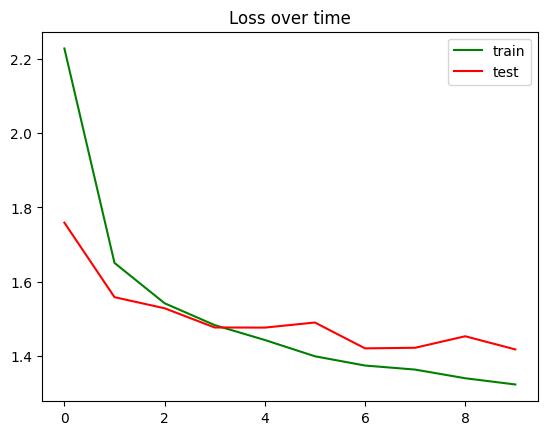

In [2]:
fig, splot = plt.subplots(1)
domain = np.arange(epochs)
splot.plot(domain, loss_ot_train, 'g',label="train")
splot.plot(domain, loss_ot_test, 'r',label="test")
splot.legend()
splot.title.set_text("Loss over time")